In [66]:
%matplotlib inline
import pandas as pd
import numpy as np
from collections import deque
from timeit import default_timer as timer
import sys, os, shutil, gc

In [2]:
# ''' Version of the packages in this work.'''
# # print("Pandas version: ",pd.__version__)
# print("Pandas version: 0.25.1")
# # print("Numpy version: ",np.__version__)
# print("Numpy version: 1.16.4")
# # print("Sys python version: ",sys.version)
# print("Sys python version: 3.7.1 | package by conda-forge [MSC v.1900 64 bit (AMD64)]")
# print("IPython: 7.8.0")
# print("IPython genutils: 0.2.0")

###  Header

In [15]:
#toy example dataset
# input_test2.dat and input_test2.dat

#synthetic datasets
# synthetic-1_fimi.dat, synthetic-2_fimi.dat and synthetic-3_fimi.dat

experiment = 'Toy' # Syn: run the synthetic data analysis; Real: run the real data analysis; 
                   # Toy: run the toy example.
toy_number = "2" # sufix of a given toy dataset [1,1-1,2]

find_overlap = False # True: find overlapped co-clusters; False: Find no overlapped co-clusters
VERBOSE = True # True: print results as a verbose mode; False: print the main results
num_of_sim = 1 # number of simulations to perform
k = -1 #max number of co-cluster that could be found. -1: default [driven by cost function]
e_obj = 0.4 # maximum error tolerance for object. -1: default [accept the maximum error]
e_att = .8 # maximum error tolerance for attribute. -1: default [accept the maximum error]

if VERBOSE: print('--->Verbose mode ON.<---')

print("Executing TRACOCLUS method")
if experiment == 'Syn':
    path = "./data/synthetic/fimi/"
    syn_datasets = [path+"synthetic-1_fimi.dat",path+"synthetic-2_fimi.dat",path+"synthetic-3_fimi.dat"]
    path_method = "OutputAnalysis\ococlus"
    check_path(path_method)

    for ds in range(len(syn_datasets)):
        ds_name = "Syn-"+str(ds+1)
        print("\nDataset: "+ds_name)
        res = os.mkdir(path_method+"\\"+ds_name)

        for run in range(num_of_sim):
            print("Run-"+str(run+1))

            df_fimi = pd.read_csv(syn_datasets[ds], header=None, names=["transation"])
            D,co_clusters = OCoClus(df_fimi,k,e_obj,e_att) # Calling OCoClus main method

            print("")
            Rec_error(D,co_clusters)
#             print(co_clusters)
            
            omega_format = build_clustering_output_omega(co_clusters)
            OCoClus_clustering_xm = xmeasures_format(omega_format)# save to XMEASURES format C++ version
            df_gt = pd.DataFrame(OCoClus_clustering_xm)
            path = path_method+"/"+ds_name
            df_gt.to_csv(path.replace("\\","/")+"/run_"+str(run+1)+"_res_ococlus_"+ds_name+"_co.cnl", 
                         header= False,index=False, encoding='utf8')
            del omega_format, df_gt, OCoClus_clustering_xm
            gc.collect()
elif experiment == 'Real':
    k = 10
    print('Real data clustering.')
    path = "./data/real_application/"
    real_datasets = [path+"cal500_fimi.dat",path+"covid19_fimi.dat"]
    path_method = "OutputAnalysis\ococlus"
    check_path(path_method)
    
    for ds in range(len(real_datasets)):
        ds_name = real_datasets[ds].replace("/","_").split("_")[4].capitalize()
        print("\nDataset: "+ds_name)
        res = os.mkdir(path_method+"\\"+ds_name)
        
        df_fimi = pd.read_csv(real_datasets[ds], header=None, names=["transation"])
        D,co_clusters = OCoClus(df_fimi,k,e_obj,e_att) # Calling OCoClus main method
        writeFileOutput(co_clusters,ds_name,method='OCoClus',fileName='OCoClusResult_'+ds_name)
        
    print('DONE!')
elif experiment == 'Toy':
    print('Toy example')
#     input_data_pd = pd.read_csv("./data/toy_example/toy"+toy_number+"_traj.dat", header=None, names=["transation"])
    input_data_pd = pd.read_csv("./data/toy_example/toy"+toy_number+"_traj.dat", header=None, names=["transation"])
#     print(input_data_pd)
    D,co_clusters = TRACOCLUS(input_data_pd,k,e_obj,e_att)
    print(co_clusters)
    #Compute the measures
#     print("")
#     Rec_error(D,co_clusters)
else:
    print('ERROR! Choose a valid option for the experiment analysis.')

--->Verbose mode ON.<---
Executing TRACOCLUS method
Toy example
######################################
Number of trajectories: 22
Number of unique check-ins: 11
########################################
Map_attribute_to_id:{'hotel': '0', 'trabalho': '1', 'academia': '2', 'restaurante': '3', 'casa': '4', 'farmacia': '5', 'parque': '6', 'estadio': '7', 'padaria': '8', 'festa': '9', 'aeroporto': '10'}

Map_id_to_attribute:{'0': 'hotel', '1': 'trabalho', '2': 'academia', '3': 'restaurante', '4': 'casa', '5': 'farmacia', '6': 'parque', '7': 'estadio', '8': 'padaria', '9': 'festa', '10': 'aeroporto'}

Frequence_per_poi:{'0': 13, '1': 30, '2': 13, '3': 10, '4': 23, '5': 2, '6': 2, '7': 1, '8': 1, '9': 1, '10': 4}

Trajectories: {'0': ['0', '1', '2', '3', '1', '0'], '1': ['4', '1', '2', '3', '4'], '2': ['5', '1', '2', '4'], '3': ['6', '2', '3', '4'], '4': ['5', '2', '3', '7'], '5': ['4', '2', '1', '4'], '6': ['4', '8', '4', '1', '2', '1', '4'], '7': ['4', '1', '2', '1', '4'], '8': ['0', '1', '2

## Evaluation (Omega index, overlapped F1, ONMI)

In [ ]:
%%bash
#!/bin/bash
### omega index and f-score
### ./xmeasures -o -fp -ku -O gt.txt cls2.txt
# pwd
# ls

if [ -d "xmeasures/OutputAnalysis/ococlus" ] 
then
#     echo "Directory exists."
    rm -R xmeasures/OutputAnalysis/ococlus
else
    echo "Error: Directory does not exists."
fi

cp -R OutputAnalysis xmeasures
cd xmeasures/

#Method: [Ococlus]
#ground-truth: [gt_xm_s1_co.cnl,gt_xm_s2_co.cnl,gt_xm_s3_co.cnl]
for i in 1 2 3 # index of synthetic datasets
# for i in 1
do
#     for file in OutputAnalysis/ococlus/Syn-${i}/*
    for file in OutputAnalysis/ococlus/Syn-${i}/*
    do
    #     echo " $(grep -c '' ${file})"
        res=$(grep -c '' ${file})
    #     echo "${file} lines equal to: ${res}"

        if [ ${res} != 0 ]
        then 
            echo " "
            echo "File ${file} is not empty. It has ${res} lines."
    #         echo "Empty file"
            ./xmeasures -o -fp -ku -O ./gts/gt_xm_s${i}_trad.cnl ${file} &
            echo " "
        else
              echo "File ${file}"
              echo "Empty file. SKIPPED!"
        fi
#     # wait until all child processes are done
#     wait
    done
    echo " "
    # wait until all child processes are done
    wait
done

### ONMI

In [ ]:
%%bash
#!/bin/bash
#### ONMI
#### ./onmi file1 file2

cd xmeasures

#Method: [Ococlus]
#ground-truth: [gt_xm_s1_trad.cnl,gt_xm_s2_trad.cnl,gt_xm_s3_trad.cnl]
for i in 1 2 3 # index of synthetic datasets
# for i in 1
do
    for file in OutputAnalysis/ococlus/Syn-${i}/*
    do
    #     echo " $(grep -c '' ${file})"
        res=$(grep -c '' ${file})
    #     echo "${file} lines equal to: ${res}"

        if [ ${res} != 0 ]
        then 
            echo " "
            echo "File ${file} is not empty. It has ${res} lines."
    #         echo "Empty file"
            ./onmi ./gts/gt_xm_s${i}_trad.cnl ${file} &
            echo " "
        else
              echo "File ${file}"
              echo "Empty file. SKIPPED!"
        fi
#     # wait until all child processes are done
#     wait
    done
    echo " "
    # wait until all child processes are done
    wait
done

# TraCoClus algorithm

This is the main algorithm of TraCoClus.

In [113]:
er = '0-3-1-4-0-1'
er2 = er.split('-')
print(er2)
# print(er2.nunique())
def change_vect_cont(queue):
    queue[0] = 'Q'

['0', '3', '1', '4', '0', '1']


In [115]:
my_vect = [1,2,8,4]
change_vect_cont(my_vect)
print(my_vect)

['Q', 2, 8, 4]


In [67]:
import seaborn as sns
# %matplotlib inline
import matplotlib.pyplot as plt

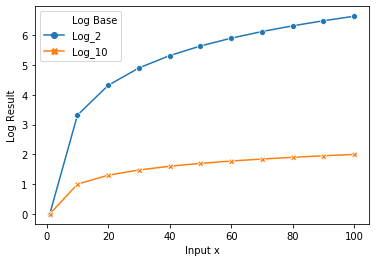

In [77]:
max_tested_atts = np.log2(10)
vec_log_num = [1,10,20,30,40,50,60,70,80,90,100]#,250,500]#,750,1000]#,1500,2000,3000,5000,7500,10000]
base = [2,10]
df_log_base_diff = pd.DataFrame(columns = ['Input x','Log Result','Log Base'])
popupalte_df_dict = {'Input x':0,'Log Result':0,'Log Base':''}

for base_i in base:
    popupalte_df_dict['Log Base'] = 'Log_'+str(base_i)
    for num in vec_log_num:
        popupalte_df_dict['Input x'] = num
#         if base_i == 2:
#         popupalte_df_dict['Log Result'] = np.log2(num)    
        popupalte_df_dict['Log Result'] = np.log(num)/np.log(base_i)
#         else:
#             popupalte_df_dict['Log Result'] = np.log10(num)
        df_log_base_diff = df_log_base_diff.append(popupalte_df_dict, ignore_index=True)
df_log_base_diff.head()
sns.lineplot(data=df_log_base_diff, x="Input x", y="Log Result", hue="Log Base", style="Log Base",
             markers=True, dashes=False)
# plt.show()
# print(max_tested_atts)

In [140]:
D,co_clusters = TRACOCLUS(input_data_pd,k,e_obj,e_att)

######################################
Number of trajectories: 22
Number of unique check-ins: 11
########################################
Map_attribute_to_id:{'hotel': '0', 'trabalho': '1', 'academia': '2', 'restaurante': '3', 'casa': '4', 'farmacia': '5', 'parque': '6', 'estadio': '7', 'padaria': '8', 'festa': '9', 'aeroporto': '10'}

Map_id_to_attribute:{'0': 'hotel', '1': 'trabalho', '2': 'academia', '3': 'restaurante', '4': 'casa', '5': 'farmacia', '6': 'parque', '7': 'estadio', '8': 'padaria', '9': 'festa', '10': 'aeroporto'}

Frequence_per_poi:{'0': 13, '1': 30, '2': 13, '3': 10, '4': 23, '5': 2, '6': 2, '7': 1, '8': 1, '9': 1, '10': 4}

Trajectories: {'0': ['0', '1', '2', '3', '1', '0'], '1': ['4', '1', '2', '3', '4'], '2': ['5', '1', '2', '4'], '3': ['6', '2', '3', '4'], '4': ['5', '2', '3', '7'], '5': ['4', '2', '1', '4'], '6': ['4', '8', '4', '1', '2', '1', '4'], '7': ['4', '1', '2', '1', '4'], '8': ['0', '1', '2', '1', '0'], '9': ['4', '1', '4'], '10': ['4', '1', '9'], '11':

In [2]:
def populate_queue(poi_freq_dict):
#     print([{k:v} for k,v in poi_freq_dict.items()])
    queue = deque()
    [queue.append([k,v]) for k,v in poi_freq_dict.items()]
    return queue  

In [3]:
def check_sequence(trajectory_dataset_dict_list, candidate_trajectories_sequence_set, test_traj_sequence):
    '''This method receive 3 parameters: 
       1) trajectory dataset as a dict->list | x['key']:[...];
       2) trajectories indeces that contains the tested check-ins as a set;
       3) the given tested sequence of check-ins as a string
    '''
    new_set_trajectories = set()
    position_pois_per_traj_list = {}
#     test_traj_sequence = test_traj_sequence.strip()
    for traj_id in candidate_trajectories_sequence_set:

        try:
#             traj_dataset = '-'.join(trajectory_dataset_dict_list[traj_id]).strip()
            test_subsequence, positions_at_traj = is_subsequence(trajectory_dataset_dict_list[traj_id],test_traj_sequence.split('-'))
            if test_subsequence:
#                 print('OK->',end=' ')
#                 print(traj_id,positions_at_traj)
                new_set_trajectories.add(traj_id)
                position_pois_per_traj_list[traj_id] = positions_at_traj
        except Exception as error:
            print(error)
#         print('{}-> {}'.format(traj_id,trajectory_dataset_dict_list[traj_id]))
#     print('Sequence "{}" is present in trajectories: {}'.format(test_traj_sequence,new_set_trajectories))
    return new_set_trajectories, position_pois_per_traj_list

In [4]:
def is_subsequence(sequence, subsequence):
    '''This sub method receive two arrays: 
       first one is the sequence and second one is the tested subsequence.'''
    n = len(sequence)
    m = len(subsequence)
    position_poi_sequence = []
    
    # Two pointers to traverse the arrays
    i = 0; j = 0;
 
    # Traverse both arrays simultaneously
    while (i < n and j < m):
 
        # If element matches
        # increment both pointers
        if (sequence[i] == subsequence[j]):
            position_poi_sequence.append(str(i))
            i += 1
            j += 1
 
            # If array B is completely
            # traversed
            if (j == m):
                return True, position_poi_sequence
         
        # If not,
        # increment i and reset j
        else:
            position_poi_sequence = []
            i = i - j + 1
            j = 0
         
    return False,None

In [393]:
test_dataset = {'0':['1','4','6','1','10'],'1':['3','6','7'],'2':['7','9','5'],'3':['4','6','1','10']
                ,'4':['9','5']}
test_candidate = set(['0','1','2','3','4'])
test_sequence = '1-10'
mySet, myPos = check_sequence(test_dataset,test_candidate,test_sequence)
print([rows+test_sequence.split('-')[poi_id]+poi_pos for rows in mySet 
 for poi_id in range(len(test_sequence.split('-'))) for poi_pos in myPos[rows][poi_id]])
form_elements(mySet,test_sequence,myPos)

3 ['2', '3']
0 ['3', '4']
['013', '0104', '312', '3103']


{'0104', '013', '3103', '312'}

In [5]:
def form_elements(trajs_index_set, tested_sequence, poi_positions_trajectories_dict_list):
    '''
    This method returns a set of elements.
    Each element is formed by the traj ID, poi ID in the sequence and its respective position at traj ID.
    Ex: set(['013', '0104', '312', '3103'])
        '013': 0-> traj ID, 1-> poi ID, and 3-> position of poi ID at traj ID
    '''
    tested_sequence = tested_sequence.split('-')
    return set([trajID+tested_sequence[poi_id]+poi_pos for trajID in trajs_index_set 
                for poi_id in range(len(tested_sequence)) 
                for poi_pos in poi_positions_trajectories_dict_list[trajID][poi_id]])

In [124]:
clusA = set([1,2,3,4,5])
dict_cc = {'0': {'cc_elements':set([5,6,7,8,9])},'1': {'cc_elements':set([4,5,6,7,8])},
           '2': {'cc_elements':set([5,4,3,2,1])}}
overlap_coefficient(clusA,dict_cc)
# print(overlap_coefficient(clusA,dict_cc))

1.0

In [123]:
def overlap_coefficient(clusterA, discovered_cc):
    max_overlap = 0
    
    for key, value in discovered_cc.items():
#         print(key,value)
        elements_intersection = len(clusterA.intersection(discovered_cc[key]['cc_elements']))
#         print(elements_intersection)
        curr_overlap = elements_intersection/np.min([len(clusterA),len(discovered_cc[key]['cc_elements'])])
#         print(curr_overlap)
        
        if curr_overlap > max_overlap:
            max_overlap = curr_overlap
            
    return max_overlap

In [136]:
def TRACOCLUS(input_D, k=-1, e_obj=-1, e_att=-1):
    ### variable declaration
    if k == -1:
        k=sys.maxsize
    if e_obj == -1:
        e_obj = 1
    if e_att == -1:
        e_att = 1
    
    cost_model = sys.float_info.max # initial cost function of the model
    num_of_coclusters = 0
    D = []
    final_coclusters = [] # store the attribute and objects clusters. final_coclusters[[C1_att,C1_obj],[Ck_att,Ck_obj]]
    pattern_model = [set(),set()]# Union between the found co-clusters [list of obj,list of att]
    cost_per_cocluster = []# stores the cost to build the cocluster
    history_cost_model = []
    ###
    
#     D,N,data_dict,data_res_dict,map_id_to_attribute = get_data(input_D)
    map_id_to_attribute_dict, S_poi_freq_dict, poi_at_trajs_dict_set, trajs_data_dict_list = get_data(input_D)
    
    overlap_coef_threshold = 0.5
    final_coclusters = {}
    final_clustered_elements = set()
    
    start = timer()
    for iter_k in range(2):
        print('\nSearching co-cluster: ',iter_k+1)
        print('')
        print('S: ',S_poi_freq_dict)
        S_poi_freq_dict = sort_attributes(S_poi_freq_dict)
        s_poi_freq_queue_list = populate_queue(S_poi_freq_dict)
        print(type(s_poi_freq_queue_list))
        print('s*: ',s_poi_freq_queue_list)
        print(s_poi_freq_queue_list[0])
        print(type(s_poi_freq_queue_list[0]))
        print('')
        
        cocluster_sequence_str = ''
        cocluster_attributes_list = ''
        cocluster_index_rows_set = set()
        cocluster_elements_set = set()
        cocluster_cost_function = sys.maxsize
        
        for poi_name, poi_frequence in S_poi_freq_dict.items():
#             print(poi_name,poi_frequence)
            if cocluster_sequence_str == '':
                head_sequence_str = poi_name
                trajectories_head_sequence_set = poi_at_trajs_dict_set[poi_name]
                tail_sequence_str = poi_name
                trajectories_tail_sequence_set = poi_at_trajs_dict_set[poi_name]

                for poi_node_queue in s_poi_freq_queue_list:
    #                 print(poi_node_queue)
    #                 print(poi_node_queue[0],poi_node_queue[1])

                    #### test POI at the HEAD ###
                    tmp_head_sequence_str = head_sequence_str
                    head_sequence_str = poi_node_queue[0]+'-'+head_sequence_str
                    print('-> Head sequence: ',head_sequence_str)
                    tmp_traj_set = trajectories_head_sequence_set
                    trajectories_head_sequence_set = trajectories_head_sequence_set.intersection(poi_at_trajs_dict_set[poi_node_queue[0]])
                    trajectories_head_sequence_set, position_poi_per_traj_head = check_sequence(trajs_data_dict_list,
                                                                                                trajectories_head_sequence_set,
                                                                                                head_sequence_str)
                    
                    if len(trajectories_head_sequence_set) > 0:
                        print('Trajectories with this sequence: {}'.format(trajectories_head_sequence_set))
                        elements_head_sequence = form_elements(trajectories_head_sequence_set,
                                                               head_sequence_str,
                                                               position_poi_per_traj_head)    
                        overlapped_elements = elements_head_sequence.intersection(final_clustered_elements)
                        cost_head_sequence = cost_function(len(trajectories_head_sequence_set),
                                                           len(head_sequence_str.split('-')),
                                                           len(overlapped_elements))
                        overlap_coef_head = overlap_coefficient(elements_head_sequence,final_coclusters)
                        print('Head cost: {} and overlap_coef: {}.'.format(cost_head_sequence,
                                                                           overlap_coef_head))
                    else:
                        print('Tested head sequence "{}" does NOT exist!'.format(head_sequence_str))
                        trajectories_head_sequence_set = tmp_traj_set
                        head_sequence_str = tmp_head_sequence_str
                        cost_head_sequence = sys.maxsize
                        overlap_coef_head = 1
                    #### END test HEAD sequence ####

                    #### test POI at the TAIL ####
                    tmp_tail_sequence_str = tail_sequence_str
                    tail_sequence_str = tail_sequence_str+'-'+poi_node_queue[0]
                    print('-> Tail sequence: ',tail_sequence_str)
                    tmp_traj_set = trajectories_tail_sequence_set
                    trajectories_tail_sequence_set = trajectories_tail_sequence_set.intersection(poi_at_trajs_dict_set[poi_node_queue[0]])
                    trajectories_tail_sequence_set, position_poi_per_traj_tail = check_sequence(trajs_data_dict_list,
                                                                                                trajectories_tail_sequence_set,
                                                                                                tail_sequence_str)
                    
                    if (len(trajectories_tail_sequence_set) > 0):
                        print('Trajectories with this sequence: {}'.format(trajectories_tail_sequence_set))
                        elements_tail_sequence = form_elements(trajectories_tail_sequence_set,
                                                               tail_sequence_str,
                                                               position_poi_per_traj_tail)
                        overlapped_elements = elements_tail_sequence.intersection(final_clustered_elements)
                        cost_tail_sequence = cost_function(len(trajectories_tail_sequence_set),
                                                           len(tail_sequence_str.split('-')),
                                                           len(overlapped_elements))
                        overlap_coef_tail = overlap_coefficient(elements_tail_sequence,final_coclusters)
                        print('Tail cost: {} and overlap_coef: {}.'.format(cost_tail_sequence,
                                                                           overlap_coef_tail))
                    else:
                        print('Tested tail sequence "{}" does NOT exist!'.format(tail_sequence_str))
                        trajectories_tail_sequence_set = tmp_traj_set
                        tail_sequence_str = tmp_tail_sequence_str
                        cost_tail_sequence = sys.maxsize
                        overlap_coef_tail = 1
                    #### END test TAIL sequence ####


                    print('Current co-cluster cost: ',cocluster_cost_function)
                    print('Queue s* BEFORE to upadate: ',s_poi_freq_queue_list)
                    
                    ### test if some sequence can improve the current co-cluster
                    improved_cocluster = False
                    if ((cost_head_sequence < cost_tail_sequence) and 
                        (cost_head_sequence <= cocluster_cost_function) and 
                        (overlap_coef_head <= overlap_coef_threshold)):
                        print('Co-cluster improved with HEAD sequence.')
                        
                        # update the nodes of queue s.
                        update_queue_s(cocluster_sequence_str,head_sequence_str,
                                       s_poi_freq_queue_list,poi_node_queue)
                        
                        cocluster_sequence_str = head_sequence_str
                        cocluster_attributes_list = head_sequence_str.split('-')
                        cocluster_index_rows_set = trajectories_head_sequence_set.copy()
                        cocluster_elements_set = elements_head_sequence.copy()
                        cocluster_cost_function = cost_head_sequence
                        improved_cocluster = True
                    elif ((cost_tail_sequence < cost_head_sequence) and 
                          (cost_tail_sequence <= cocluster_cost_function)):
                        print('Co-cluster improved with TAIL sequence.')
                        
                        # update the nodes of queue s.
                        update_queue_s(cocluster_sequence_str,tail_sequence_str,
                                       s_poi_freq_queue_list,poi_node_queue)
                        
                        cocluster_sequence_str = tail_sequence_str
                        cocluster_attributes_list = tail_sequence_str.split('-')
                        cocluster_index_rows_set = trajectories_tail_sequence_set.copy()
                        cocluster_elements_set = elements_tail_sequence.copy()
                        cocluster_cost_function = cost_tail_sequence
                        improved_cocluster = True
                    
                    if improved_cocluster:
                        trajectories_head_sequence_set = cocluster_index_rows_set
                        head_sequence_str = cocluster_sequence_str
                        trajectories_tail_sequence_set = cocluster_index_rows_set
                        tail_sequence_str = cocluster_sequence_str
#                         ## decrementar attributo em s
#                         print('Poi node: ', poi_node_queue)
#                         poi_node_queue[1] -= 1
#                         print('Poi node: ', poi_node_queue)
                    else:
                        print('Tested sequences do not improved the current co-cluster.')
                        trajectories_head_sequence_set = tmp_traj_set
                        head_sequence_str = tmp_head_sequence_str
                        trajectories_tail_sequence_set = tmp_traj_set
                        tail_sequence_str = tmp_tail_sequence_str
                    
                    print('Queue s* AFTER to update: ',s_poi_freq_queue_list)

                    print('')
    #                 tail_sequence_str = tail_sequence_str+'-'+poi_node_queue[0]
    #                 print('Tail: ',tail_sequence_str)
            
            else:
                print('Co-cluster identified. Go to the next searching.')
                final_coclusters.update({str(iter_k):{'cc_objs':cocluster_index_rows_set,
                                                      'cc_atts':cocluster_sequence_str,
                                                      'cc_elements':cocluster_elements_set}})
                final_clustered_elements = final_clustered_elements.union(cocluster_elements_set)
                print('Main list S BEFORE to update: ',S_poi_freq_dict)
                for attribute in cocluster_attributes_list:
                    S_poi_freq_dict[attribute] -= 1
                print('Main list S AFTER to update: ',S_poi_freq_dict)
#                 partial = timer()
#                 print('Cluster "{}" finished at time "{}".'.format((iter_k+1),(partial-start))
                break
            
            
        ## into loop of iteration k
        
        partial = timer()
        print('Cluster "{}" finished at time "{}".'.format(iter_k+1,partial-start))
    ## out of loop iteraton k
    end = timer()
    print('Total clustering time: ',str(end-start))
    print('\nFinal co-clusters: ',final_coclusters)
        # candidate_cocluster = find_base_cocluster()
        # max_cocluster = expand_cocluster()
        # testa se max_cocluster != VAZIO e ainda não descoberto
            # OK: salva max_cocluster no conjunto de co-clusters
            #     atualiza a lista de frequencia S
            # FAIL: terminar busca por novos co-clusters
    
    # return conjunto de co-clusters
            
    
    
#     print("Data dict (in main ococlus):"+str(data_dict))
#     for itertator in range(1,k+1):
#         print("Iterator: ",itertator)
#         if VERBOSE:
#             print("Pattern model: ",pattern_model)
#         C,E,new_cost_dense = find_dense_cocluster(data_dict, data_res_dict)
#         if new_cost_dense >= 0:
#             print("No relevant co-cluster can be found anymore.")
#             break    
#         C_expanded = expand_dense_cocluster(C, E, data_dict,e_obj,e_att)
#         print("Expanded: "+str(C_expanded))

#         print("")
#         new_cost = cost_function(len(pattern_model[0].union(C[1])),
#                                               len(pattern_model[1].union(set(C[0]))))
#         if VERBOSE:
#             print("Dense co-cluster cost: ",new_cost_dense)
#             print("Current model cost: ",cost_model)
#             print("New model cost with the found co-cluster: ",new_cost)
#             print("Attribute cluster:"+str(C[0])+", Object cluster: "+str(C[1]))
#             print(" ")
        
#         if new_cost < cost_model:
#             final_coclusters.append(C)
#             cost_model = new_cost
#             num_of_coclusters += 1
#             data_res_dict = update_residual_dataset(data_res_dict,C[0],C[1])
#             pattern_model[0] = pattern_model[0].union(C[1])
#             pattern_model[1] = pattern_model[1].union(set(C[0]))
#         else:
#             print("No co-cluster can be found anymore.")
#             break
    
#     print("Find global co-cluster is done.")
    
#     if find_overlap:
#         attributes_per_cluster = []
#         objects_per_cluster = []
#         for i in range(len(final_coclusters)):
#             attributes_per_cluster.append(set(list(map(int,final_coclusters[i][0]))))
#             objects_per_cluster.append(final_coclusters[i][1])

#         print("\nFind derived overlapped co-clusters method")
#         attribute_clusters, objects_clusters = findOverlap(attributes_per_cluster,objects_per_cluster)

#         final_coclusters = []
#         for i in range(len(attribute_clusters)):
#             final_coclusters.append([attribute_clusters[i],objects_clusters[i]])

#         print("\nNon-overlapped and overlapped co-clusters.")
#         print("Number of co-clusters: ",len(final_coclusters))
#         if VERBOSE:
#             print("Final co-clusters: ",final_coclusters)
#     else:
#         print("\nNon-overlapped co-clusters.")
#         print("Number of co-clusters: ",num_of_coclusters)
# #         for i in range(len(final_coclusters)):
# #             tmp_data = final_coclusters[i][1]
# #             final_coclusters[i][1] = list(tmp_data)
#         if VERBOSE:
#             print("Final co-clusters: ",final_coclusters)
    
#     print("Final co-clusters:"+str(final_coclusters))
    
#     print("Remap the attributes to its original label (final co-clusters):")
#     # go back to the original att map
#     for i in range(len(final_coclusters)):
#         cluster_att_id = final_coclusters[i][0]
#         for j in range(len(cluster_att_id)):
#             final_coclusters[i][0][j] = map_id_to_attribute[str(cluster_att_id[j])]
            
    return D,final_coclusters

In [90]:
f = {}
f['1'] = {}
f['1'].update({'cc_objs':[]})
f['1'].update({'cc_atts':[]})
f['1'].update({'cc_elements':[]})
print(f)
print(f['1']['cc_objs'])
f.update({'2':{}})
print(f)


{'1': {'cc_objs': [], 'cc_atts': [], 'cc_elements': []}}
[]
{'1': {'cc_objs': [], 'cc_atts': [], 'cc_elements': []}, '2': {}}


In [7]:
def update_queue_s(cocluster_sequence_str,tested_sequence_str,s_poi_freq_queue_list,poi_node_queue):
    '''
    Method to update the nodes in queue s. It decrements the value of a given node in s.
    The input are:
        1. The current string sequence of a cocluster;
        2. The tested string sequence to improve a cocluster;
        3. The queue s;
        4. A single node of queue s.
    '''
    # update list s when the first sequence is identified
    if cocluster_sequence_str == '':
        tmp_split = tested_sequence_str.split('-')
        for attribute in tmp_split:
            for node_s in s_poi_freq_queue_list:
                if attribute == node_s[0]:
                    node_s[1] -= 1
                    break
    else: # update a single node in case a sequence is already discovered
        poi_node_queue[1] -= 1

In [336]:
a1 = ['a','b','c','d']
a2 = [1,2,3,4]
[str(i)+str(j) for i in a1 for j in a2]

['a1',
 'a2',
 'a3',
 'a4',
 'b1',
 'b2',
 'b3',
 'b4',
 'c1',
 'c2',
 'c3',
 'c4',
 'd1',
 'd2',
 'd3',
 'd4']

In [122]:
a = np.array([1,1,1,0,0,0,0])
b = np.array([1,1,3,0,0,0,0])
c = np.outer(a,b)
print(c)
d = (c*0)+1
print(d)
print(c+d)
e = d*4
print(e)
f = d-e
print(f)
print(sum(sum(f)))

[[1 1 3 0 0 0 0]
 [1 1 3 0 0 0 0]
 [1 1 3 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]
[[2 2 4 1 1 1 1]
 [2 2 4 1 1 1 1]
 [2 2 4 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]
[[4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4]]
[[-3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3]]
-147


In [44]:
def myFunc(e):
    return e[:][1]

er = [['f',2],['h',5],['t',1]]
print(er)
er.sort()
print(er)
er.sort(reverse=True, key=myFunc)
print(er)
er[0][1] -= 1
print(er)

[['f', 2], ['h', 5], ['t', 1]]
[['f', 2], ['h', 5], ['t', 1]]
[['h', 5], ['f', 2], ['t', 1]]
[['h', 4], ['f', 2], ['t', 1]]


### Find dense co-cluster

In [8]:
def find_dense_cocluster(input_dataset, residual_dataset):
    '''
    Input
        input_dataset: a dictionary with the list of objects per attribute. input_dataset[att] -> [objects_in_att]
        residual_dataset: it is a copy of input_dataset used to sort the attributes
    
    Output
        C: A dense co-cluster. It is a array with a list of attributes and a set of objects. C[att_list,obj_set]
    '''
    print("Find dense cocluster method.")
    att_dense_cocluster_list = []
#     att_dense_cocluster_set = set([])
    obj_dense_cocluster_list = []
    att_extension_list = []
    cost_dense_cocluster = sys.float_info.max
    
    sads = sort_att_ds(residual_dataset)
#     print("Sorted att: ",sads)
    cc_att = sads[0]
#     att_dense_cocluster_list.append(cc_att)
    att_dense_cocluster_list.append(cc_att)
    obj_dense_cocluter_set = set(residual_dataset[cc_att]) # get the objs forthe given attribute cc_att
    count_group_att = 1
#     cost_dense_cocluster = cost_function(len(pattern_model[0].union(obj_dense_cocluter_set)),
#                                          len(pattern_model[1].union(set(cc_att))))
    new_cost_function = cost_function(len(obj_dense_cocluter_set), count_group_att)
    if VERBOSE:
        print("New cost: "+str(new_cost_function)+", Cost dense: "+str(cost_dense_cocluster))
    cost_dense_cocluster = new_cost_function
    
    for next_att in range(1,len(sads)):
        cc_att_test = sads[next_att]
#         print("Attribute: ",cc_att_test)
        curr_cc_att = set(residual_dataset[cc_att_test])
        intersection_objs = obj_dense_cocluter_set.intersection(curr_cc_att)
#         print("Intersection test: ",intersection_objs)
        tmp = att_dense_cocluster_list.copy()
        tmp.append(cc_att_test)
#         new_cost_function = cost_function(len(pattern_model[0].union(intersection_objs)),
#                                           len(pattern_model[1].union(set(tmp))))
        new_cost_function = cost_function(len(intersection_objs),count_group_att+1)
#         print(intersection_objs,curr_cc_att)
#         print(len(intersection_objs),count_group_att+1)
        if VERBOSE:
            print("New cost: "+str(new_cost_function)+", Cost dense: "+str(cost_dense_cocluster))
            
        if  new_cost_function <= cost_dense_cocluster:
            att_dense_cocluster_list.append(cc_att_test)
            obj_dense_cocluter_set = intersection_objs
            cost_dense_cocluster = new_cost_function
            count_group_att += 1
        else:
            att_extension_list.append(cc_att_test)
    
    C = [att_dense_cocluster_list, obj_dense_cocluter_set]
    print(att_dense_cocluster_list)
    
    # no good rectangle was found
    if cost_dense_cocluster >= 0:
        att_extension_list = []
        C = [[],set()]
    else:
        C = [att_dense_cocluster_list, obj_dense_cocluter_set]
    
    return C, att_extension_list, cost_dense_cocluster

In [ ]:
t= [1,2,3,4,5,6,7,8]
print(t)
push_to_end = 3
complete_cicle = False
reload = True
print(t.pop(2))
print(t)
t= [1,2,3,4,5,6,7,8]
print(t)
# while(reload and complete_cicle != True):
#     for i in range(len(t)):
#         if t[i] == push_to_end:
#             tmp = t.pop(i)
#             t.append(tmp)
#             complete_cicle == True
#         else:
#             print(t[i])
#         if push_to_end == t[i] and complete_cicle == True:
#             reload = False
#             break
            


### Expand dense co-cluster

In [9]:
def expand_dense_cocluster(C,E,att_data_dict,e_obj,e_att):
    '''
    INPUT
        C = a tuple(list_atts, set_objs); list_atts has the list of attributes and set_objs is a set of objects
        E = list of attributes not present in C_a to be tested
        att_data_dict = a dict with list of objects per att; att_data_dict[att] -> [objects]
        e_obj = maximum object error 
        e_att = maximum attribute error 
    
    OUTPUT
        
    '''
    print("Expand co-cluster method.")
    added_att = True
    
    if not C[0]: # nothing good to discover
        pass
    else:
        curr_cost = cost_function(len(C[1]), len(C[0]),0,0)
        noise_added = 0 # the quantanty of noise added in the cluster during the process
        while(added_att):
            # try to add new objects to cocluster C
            try_new_objs = set(np.arange(0,len(D))).difference(C[1]) # get the objects not present in C
            if VERBOSE:
                print("# Try to extend the list of Objects #")
            for obj in try_new_objs:
                obj_quantanty = 0
                for att in C[0]:
                    if D[obj][int(att)] == 1:
                        obj_quantanty += 1
                if not_too_noisy(obj_quantanty, C, e_obj, e_att, att_data_dict, E, "obj"):
#                     print("Ruído valor: ",not_noise_val)
                    if VERBOSE:
                        print("OBJ->"+str(obj),end=" | ")
                    new_cost = cost_function(len(C[1])+1,len(C[0]),0,(noise_added+(len(C[0])-obj_quantanty)))
                    if new_cost <= curr_cost:
                        if VERBOSE:
                            print("New_cost:"+str(new_cost)+" ; Curr_cost:"+str(curr_cost))
                        
                        C[1].add(obj)
                        curr_cost = new_cost
                        noise_added += (len(C[0])-obj_quantanty)
                else:
                    if VERBOSE:
                        print("Object too noisy to be added. (Obj: "+str(obj)+")")

            added_att = False
            # try to add new attributes to cocluster C
            if VERBOSE:
                print("# Try to extend the list of Attributes #")
            
            while(len(E) != 0):
                att = E.pop(0)
                if VERBOSE:
                    print("ATT->"+str(att), end= " | ")
                att_obj_quantanty = len(C[1].intersection(set(att_data_dict[att])))
                if not_too_noisy(att_obj_quantanty, C, e_obj, e_att, att_data_dict, E, "att"):
                    new_cost = cost_function(len(C[1]),len(C[0])+1,0,(noise_added+(len(C[1])-att_obj_quantanty)))
                    
                    if VERBOSE:
                        print("New_cost:"+str(new_cost)+" ; Curr_cost:"+str(curr_cost))
                    
                    if new_cost <= curr_cost:
                        C[0].append(str(att))
                        curr_cost = new_cost
                        added_att = True
                        noise_added += (len(C[1])-att_obj_quantanty)
                        break
                else:
                    if VERBOSE:
                        print("Attribute too noisy to be added. (Att: "+str(att)+")")

### Find overlapped co-clusters

In [10]:
def findOverlap(SetsC,SetsR):
    '''
    INPUT
        SetsC: It has K sets of attributes regarding each attribute cluster
        SetsR: It has K sets of objects regarding each object cluster
    
    OUTPUT
        columnClusters: A list with the attribute clusters
        rowClusters: A list with the object clusters
    '''
    newSetsColumns = []
    newSetsRows = []
    
    # merge sets that can overlap
    merge(SetsC,SetsR,newSetsColumns,newSetsRows)

    #Removing sets with redundant information
    removeSubsets(newSetsColumns,newSetsRows)
    
    columnClusters = newSetsColumns
    rowClusters = newSetsRows
    return columnClusters,rowClusters

# Support functions for the algorithms

In [8]:
def get_data(input_data):
    '''
    This method will assign the variables used by the algorithm.
    
    INPUT
        input_data: A panda dataframe of the input data file.
    
    OUTPUT
        D: A binary matrix from the input data.
        N: A noise binary matrix with the same size of D.
        data_dict: A dictionary to store D as a vertical representation.
        data_res_dict: A copy of data_dict used to sort the attributes of D and find unconvered elements.
        
    '''
    
    data_pd = input_data #txt file with sequence of check-ins (POI)
    frequence_per_poi_dict = {} # store the frequence of a POI as "POI": num_of_occurrences
    poi_at_trajs_dict_set = {}  # store a set with each index line (tid trajectory) that contains a given POI.
                            # "POI": set(0,1,4,...); It is the S variable
#     global data_res_dict
    uncover_poi_dict = {} # It is the s* variable
#     global D # input data as a binary matrix
#     global N # noise matrix with the same size of D
    num_of_objects = 0
    num_of_attributes = 0
    map_id_to_attribute = {} # map the 
    map_attribute_to_id = {} # map the
    trajectory_dict = {} # it stores the trajectories with its check-ins. "TID": [POI1,POI2,...]
#     max_val_att = 0 
    att_id = 0 # assign an ID to each attribute
    
    # read each line
    for index, row in data_pd.iterrows():
        num_of_objects+=1
        object_data = row[0].split(" ")
#         trajectory_dict[str(index)] = {}
#         trajectory_dict[str(index)] = object_data
        trajectory_dict[str(index)] = []
        
#         for attribute in object_data: # we look at each item of the given transaction
        for att_j in range(len(object_data)): # we look at each item of the given transaction
            attribute = object_data[att_j]
            
            if attribute != "":
#                 if int(attribute) > max_val_att:
#                     max_val_att = int(attribute)
#                 if attribute not in map_unique_attributes_dataset:
#                 if attribute not in map_attribute_to_id.keys():
    
                if attribute not in map_attribute_to_id: # mapping
#                     unique_attributes_dataset.append(attribute)
                    map_attribute_to_id[attribute] = str(att_id)
                    map_id_to_attribute[str(att_id)] = attribute
                    att_id += 1
                
                # substitute the check-in by its ID
                trajectory_dict[str(index)].append(map_attribute_to_id[attribute])
                
                # store the indeces containing a given POI
                if map_attribute_to_id[attribute] in poi_at_trajs_dict_set:
#                     data_dict[map_attribute_to_id[attribute]].append(index)
                    poi_at_trajs_dict_set[map_attribute_to_id[attribute]].add(str(index))
                else:
#                     data_dict[map_attribute_to_id[attribute]] = [index]
                    poi_at_trajs_dict_set[map_attribute_to_id[attribute]] = set([str(index)])
                
                # store the frequence for each POI
                if map_attribute_to_id[attribute] in frequence_per_poi_dict:
                    current_value = frequence_per_poi_dict[map_attribute_to_id[attribute]]
                    frequence_per_poi_dict[map_attribute_to_id[attribute]] = current_value + 1
                else:
                    frequence_per_poi_dict[map_attribute_to_id[attribute]] = 1
            
#             # simulate the idea of a linked list structure with a dict to facility the check
#             if att_j == 0 and len(object_data) > 1:
# #                 print("IF 1")
# #                 print(object_data[att_j])
#                 trajectory_dict[str(index)][map_attribute_to_id[attribute]] = {"Previous": "None", "Next": "None"}
#             elif att_j == 0 and len(object_data) == 1:
# #                 print("IF 2")
# #                 print(object_data[att_j])
#                 trajectory_dict[str(index)][map_attribute_to_id[attribute]] = {"Previous": "None", "Next": "None"}
#             elif att_j > 0 and att_j < (len(object_data)-1):
# #                 print("IF 3")
# #                 print(object_data[att_j])
#                 trajectory_dict[str(index)][map_attribute_to_id[attribute]] = {"Previous": map_attribute_to_id[object_data[att_j-1]],
#                                                                                "Next": "None"}
#                 trajectory_dict[str(index)][map_attribute_to_id[object_data[att_j-1]]]["Next"] = map_attribute_to_id[attribute]
#             else:
# #                 print("IF 4")
# #                 print(object_data[att_j])
#                 trajectory_dict[str(index)][map_attribute_to_id[attribute]] = {"Previous": map_attribute_to_id[object_data[att_j-1]],
#                                                                                "Next": "None"}
#                 trajectory_dict[str(index)][map_attribute_to_id[object_data[att_j-1]]]["Next"] = map_attribute_to_id[attribute]
            
        
#     print("Trajectory dict:"+str(trajectory_dict))
                    
    uncover_poi_dict = poi_at_trajs_dict_set.copy()
#     num_of_attributes = len(data_dict)
#     num_of_attributes = max_val_att+1
#     num_of_attributes = len(map_attribute_to_id)
    print("######################################")
    print("Number of trajectories: "+str(index+1))
    print("Number of unique check-ins: "+str(len(map_attribute_to_id)))
    print("########################################")
    if VERBOSE:
        print("Map_attribute_to_id:"+str(map_attribute_to_id))
        print("")
        print("Map_id_to_attribute:"+str(map_id_to_attribute))
        print("")
        print("Frequence_per_poi:"+str(frequence_per_poi_dict))
        print("")
        print("Trajectories: "+str(trajectory_dict))
        print("")
        print("POI occurring at trajectories: "+str(poi_at_trajs_dict_set))
        print("Get data is DONE!")
        
    
#     D = np.zeros((num_of_objects,num_of_attributes),dtype=int)
#     for key, values in poi_at_trajs_dict.items():
#         print("key:"+str(key)+" Values:"+str(values))
#         for line in values:
# #             D[line][int(key)] = 1
# #             D[line][map_unique_attributes_dataset[key]] = 1
# #             print(line,key)
# #             print(type(line),type(key))
#             D[line][int(key)] = 1
#     N = np.zeros((num_of_objects,num_of_attributes),dtype=int)
    
#     return D, N, poi_at_trajs_dict, data_res_dict, map_id_to_attribute
    return map_id_to_attribute, frequence_per_poi_dict, poi_at_trajs_dict_set, trajectory_dict

In [41]:
from collections import deque
my_fila = deque([{'hotel':4},{'casa':7},{'trabalho':9},{'padaria':2}])
my_fila2 = deque()
my_fila2.append({'hotel':4})
my_fila2.append({'padaria':2})
print('Fila 1: ',type(my_fila))
print('Fila 2: ',my_fila2)
print(my_fila)
my_fila.append({'festa':1})
print(my_fila)
my_fila.appendleft({'aeroporto':1})
print(my_fila)
print(my_fila[1])
my_fila.insert(1,{'padaria':3})
print(my_fila)
print(len(my_fila))
print(my_fila.pop())
print(type(my_fila[2]))
r = my_fila[4]
print(r)
print(list(r.keys())[0])
print(my_fila.index(my_fila[4],2,len(my_fila)))
print('Fila 1: ',my_fila)
print('Fila 2: ',my_fila2)
my_fila.pop()#delete from the right end
my_fila.popleft()#delete from the left end
print('Fila 1: ',my_fila)
f = my_fila.popleft()
print('Fila 1: ',my_fila)
print('Element poped: ',f)

Fila 1:  <class 'collections.deque'>
Fila 2:  deque([{'hotel': 4}, {'padaria': 2}])
deque([{'hotel': 4}, {'casa': 7}, {'trabalho': 9}, {'padaria': 2}])
deque([{'hotel': 4}, {'casa': 7}, {'trabalho': 9}, {'padaria': 2}, {'festa': 1}])
deque([{'aeroporto': 1}, {'hotel': 4}, {'casa': 7}, {'trabalho': 9}, {'padaria': 2}, {'festa': 1}])
{'hotel': 4}
deque([{'aeroporto': 1}, {'padaria': 3}, {'hotel': 4}, {'casa': 7}, {'trabalho': 9}, {'padaria': 2}, {'festa': 1}])
7
{'festa': 1}
<class 'dict'>
{'trabalho': 9}
trabalho
4
Fila 1:  deque([{'aeroporto': 1}, {'padaria': 3}, {'hotel': 4}, {'casa': 7}, {'trabalho': 9}, {'padaria': 2}])
Fila 2:  deque([{'hotel': 4}, {'padaria': 2}])
Fila 1:  deque([{'padaria': 3}, {'hotel': 4}, {'casa': 7}, {'trabalho': 9}])
Fila 1:  deque([{'hotel': 4}, {'casa': 7}, {'trabalho': 9}])
Element poped:  {'padaria': 3}


In [ ]:
g = {'C':4,'B':6,'A':[4,2]}
print(g)
print(len(g))
print('F' in g)
print(6 in g)
print(g.values())
h = set([1,2,2])
print(h)
h.add(3)
print(h)


### Too noisy (line,col)?

In [9]:
def not_too_noisy(count_presence, C, e_obj, e_att, att_data_dict, E, dimension):
    num_of_atts = len(C[0])
    num_of_objs = len(C[1])
    if dimension == "obj":
        # obj must be present in at least (1-e_obj).||C_a||
        return count_presence >= ((1-e_obj) * num_of_atts) # return true if the obj is not too noisy
    else:
        # col must be present in at least (1-e_tt).||C_o||
        return count_presence >= ((1-e_att) * num_of_objs) # return true if the att is not too noisy

### cost function

In [139]:
def cost_function(numOfObj, numOfAtt, cov=0, noise=0):
    if VERBOSE:
        print('Num. objs: {0:2d}, Num. att: {1:2d}, Num. covered: {2:2d}, Num. noise: {3:2d}'.format(numOfObj,numOfAtt,cov,noise))
#     return ((numOfObj+numOfAtt) - (numOfObj*numOfAtt)) + cov + (2*noise)
    return ((numOfObj+numOfAtt) - (numOfObj*numOfAtt)) + cov + noise

In [14]:
def merge(SetsC, SetsR, newSetsColumns, newSetsRows):
    num_of_cluster = len(SetsC)
    
    # keep the original cluster
    for set_column_i in range(len(SetsC)):
        newSetsRows.append(SetsR[set_column_i])
        newSetsColumns.append(SetsC[set_column_i])
    
    revisit = True
    while(revisit):
        revisit = False
        tmp_r = []
        tmp_c = []
        size = len(newSetsColumns)
        for i in range(size-1):
            first_r = newSetsRows[i]
            first_c = newSetsColumns[i]
            for j in range(i+1,size):
                p_intersec_r = first_r.intersection(newSetsRows[j])
                p_intersec_c = first_c.union(newSetsColumns[j])
                if len(p_intersec_r) > 0:
                    tmp_r.append(p_intersec_r)
                    tmp_c.append(p_intersec_c)
        
        for i in range(len(tmp_c)):
            change = True
            for j in range(len(newSetsColumns)):
                if tmp_c[i].issubset(newSetsColumns[j]):
                    change = False
            if change:
                newSetsRows.append(tmp_r[i])
                newSetsColumns.append(tmp_c[i])
                revisit = True
    
    # start to find and merge all possible overlapping clusters
    for set_column_i in range(num_of_cluster):
        tested_pattern = SetsR[set_column_i]
        new_cols = SetsC[set_column_i]
        overlapped = False
        
        # finds with who the tested pattern overlaps
        set_overlap_id = []
        for i in range(num_of_cluster):
            if i != set_column_i:
                if len(tested_pattern.intersection(SetsR[i])) > 0:
                    set_overlap_id.append(i)    
        
        # Discover if exist overlaps between the sets in set_overlap_id
        sub_overlap_id = []
        for i in range(len(set_overlap_id)):
            try_combine_ids = [set_overlap_id[i]]
            added = False
            for j in range(i+1,len(set_overlap_id)):
                if len(SetsR[set_overlap_id[i]].intersection(SetsR[set_overlap_id[j]])) > 0:
                    try_combine_ids.append(set_overlap_id[j])
                    added = True
            sub_overlap_id.append(try_combine_ids)
        #Check if some pattern is isolated and was not added
        for id_pattern in set_overlap_id:
            added = False
            for combined_ids in sub_overlap_id:
                if id_pattern in combined_ids:
                    added = True
            if added == False:
                sub_overlap_id.append([id_pattern])
        
        # merge the analysed pattern with the overlapped combined patterns ids
        for pattern_ids in sub_overlap_id:
            tested_pattern = SetsR[set_column_i]
            new_cols = SetsC[set_column_i]
            for pattern_id in pattern_ids:
                tmp = tested_pattern.intersection(SetsR[pattern_id])
                tested_pattern = tmp
                new_cols = new_cols.union(SetsC[pattern_id])
            # save the new patterns
            newSetsColumns.append(new_cols)
            newSetsRows.append(tested_pattern)

In [15]:
def removeSubsets(setsColumns,setsRows):
    finalSetsCols = []
    finalSetsRows = []
    
    again = True
    # We are out of the loop when we do not have any subset to remove
    while(again):
        again = False
        for i in range(len(setsColumns)):
            isSubset = False
            currC = setsColumns[i]
            currR = setsRows[i]
            
            for j in range(len(setsColumns)):
                if i != j:
                    nextC = setsColumns[j]
                    nextR = setsRows[j]
                    if currC.issubset(nextC) and currR.issubset(nextR):
                        isSubset = True
        
            if isSubset or len(setsRows[i]) == 0:
                setsColumns.pop(i)
                setsRows.pop(i)
                again = True
                break
    
    #converting data type back to list
    for i in range(len(setsColumns)):
        setsColumns[i] = list(setsColumns[i])
        setsRows[i] = list(setsRows[i])

### Sort attributes in dataset

In [158]:
test_dict_freq = {'10':10,'45':45,'65':9,'87':2,'0':100}
sorted_attributes = sort_attributes(test_dict_freq)

Sorted att:  {'0': 100, '45': 45, '10': 10, '65': 9, '87': 2}


In [11]:
def sort_attributes(data_res):
    
    try:
        ##usar este for caso o value seja uma lista
        freq_res_dict = {}
        for key,value in data_res.items():
            freq_res_dict[key] = len(value)

        # Create a list of tuples sorted by index 1 i.e. value field     
        listofTuples = sorted(freq_res_dict.items() , reverse=True, key=lambda x: x[1])# usar se value for lista
        # Iterate over the sorted sequence
        # for elem in listofTuples :
        #     print(elem[0] , " ::" , elem[1] )
    #     print(listofTuples)
        sorted_attributes = [elem[0] for elem in listofTuples]
    except:
        ## este é usado caso value seja um número
        sorted_attributes = {k: v for k, v in sorted(data_res.items(), reverse=True, key=lambda item: item[1])}
    
    if VERBOSE:
        print("Sorted att: ",sorted_attributes)
    return sorted_attributes

### Update residual dataset

In [12]:
def update_residual_dataset(res_data, attributes_cocluster, objects_cocluster):
    for key, value in res_data.items():
        if key in attributes_cocluster:
            diff_objs = set(res_data[key]).difference(set(objects_cocluster))
            res_data[key] = list(diff_objs)
    return res_data

### Save results - check path

In [13]:
def check_path(path_method):
    current_dir = os.getcwd()
    print(current_dir)
    res = os.path.exists(path_method)
    # clean the folder to save new data
    if res:
        #check if it is empty
        dir_empty = os.listdir(path_method)
        if len(dir_empty) != 0:
    #         shutil.rmtree("OutputAnalysis/kmeans/")
            rm = !rm -r --preserve-root './OutputAnalysis/ococlus/'*
            if not rm:
                print("OCoClus' folder was cleaned.")
    #             os.chdir(path_method)
            else:
                print("sad")
                print(rm)
        else:
    #         print("Empty!")
            pass
    #         os.chdir(path_method)
    else: # nothing exist so create it
        # trying to insert to flase directory 
        try: 
    #         os.chdir(fd) 
            os.mkdir(path_method)
            print("The path was created: "+path_method)

        # Caching the exception     
        except: 
            print("Something wrong with specified directory. Exception- ", sys.exc_info())

### Save clustering result into a txt file

In [14]:
# def writeFileOutput(cols, rows, dataset, method='OCoClus', fileName='OCoClusResult'):
def writeFileOutput(co_clusters, dataset, method='OCoClus', fileName='OCoClusResult'):
    text = ""
#    for c in range(len(data.rows_)):
#        res = [i for i, val in enumerate(data.columns_[c]) if val]
#        for j in res:
#            text += str(j)+" "

#        res = [i for i, val in enumerate(data.rows_[c]) if val]
#        text += "["
#        for j in res:
#            text += str(j)+" "
#        text += "]\n"
    
    num_of_clusters = len(co_clusters)
    
#     for c in range(len(cols)):
    for c in range(num_of_clusters):
#         for i in cols[c]:
        for i in co_clusters[c][0]: # get the attributes in cluster c
            text += str(i)+" "
        
        text += "("+str(len(co_clusters[c][1]))+") [" # get the number of objects in clusters c
        for j in range(len(co_clusters[c][1])): # save in the file each obj
            if j+1 != len(co_clusters[c][1]):
                text += str(co_clusters[c][1][j])+" "
            else:
                text += str(co_clusters[c][1][j])
        text += "]\n"
    
    #print(text)
    if method == 'Dhillon':
        f = open('./datasets/outputs/'+fileName+'.txt', 'w+')#saving at dataset folder
        f.write(text)
        f.close()
        print("Output file saved in: "+"./datasets/outputs/"+fileName+".txt")
    elif method == 'Kluger':
        f = open('./datasets/outputs/'+fileName+'.txt', 'w+')#saving at dataset folder
        f.write(text)
        f.close()
        print("Output file saved in: "+"./datasets/outputs/"+fileName+".txt")
    elif method == 'OCoClus':
        f = open('./OutputAnalysis/ococlus/'+dataset+'/'+fileName+'.txt', 'w+')#saving at dataset folder
        f.write(text)
        f.close()
        print("Output file saved in: "+"./OutputAnalysis/ococlus/"+dataset+"/"+fileName+".txt")
    else:
        print("The output file was not generated. Method option not recognized.")

# Evaluation measure

### Reconstruction error

In [20]:
def Rec_error(data,clusters):
    '''
    This evaluation measure is computed during the algorithm life time.
    '''
    reconstructed_ococlus = np.zeros(data.shape,dtype=int)
    for nc in range(len(clusters)):
        for i in clusters[nc][1]: # object cluster
            for j in clusters[nc][0]: # attribute cluster
                reconstructed_ococlus[int(i)][int(j)] = 1
    print("Reconstruction error: ",np.sum(np.bitwise_xor(data,reconstructed_ococlus)))

### Omega format

In [21]:
def build_clustering_output_omega(co_clusters):
# def build_clustering_output_omega(rowClusters,columnClusters):
    '''
    Build the clustering output format to use in the omega index evaluation from Remy Cazabet version.
    It is optional and we just present this version as a complementary information. If you are interested,
    check it out on his team work group at https://github.com/isaranto/omega_index.
    '''
    
    num_of_clusters = len(co_clusters)    
    clustering = {}
    
    for nc in range(num_of_clusters):
        rowCluster = co_clusters[nc][1]
        columnCluster = co_clusters[nc][0]
        clustering["c"+str(nc)] = []
        
        for i in rowCluster:
            for j in columnCluster:
                clustering["c"+str(nc)].append(("01"+str(i)+"02"+str(j)))
        
    return clustering

### eXascale Infolab 
We used the xmeasure and OvpNMI project that pushished evaluation measures for overlapping task. We can check it on https://github.com/eXascaleInfolab/xmeasures or https://exascale.info/. Look their project on github to know how to use it.

In [22]:
def xmeasures_format(dict_gt):
    '''
    This function build the xmeasure format to use it on their evaluation measure.
    '''
    newData = []
    for i in range(len(dict_gt)):
#         print(dict_gt['c'+str(i)])
        stringLine = dict_gt['c'+str(i)][0]
        for j in range(1,len(dict_gt['c'+str(i)])):
#             stringLine = stringLine+" "+dict_gt['c'+str(i)][j]
            stringLine += " "+dict_gt['c'+str(i)][j]
        newData.append(stringLine)
    
    return newData